# Atmospheric retrieval on *real* data with Hamiltonian MCMC
### Multi-layer atmosphere with just a single species for now $O_2$
### Now with `numpyro`

Real A0V data from HPF!


May 2020

In [1]:
%%capture
import astropy.units as u
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import hapi
hapi.db_begin('../../hapi/data/')

from jax.config import config
config.update("jax_enable_x64", False)

import jax.numpy as np
from jax import vmap, jit, grad, random
from jax.lax import stop_gradient
from jax import jacfwd
from functools import partial

import time

import pandas as pd

In [2]:
@jit
def gamma_of_p_and_T(p, T, p_self, n_air, gamma_air_ref, gamma_self_ref):
    '''Compute the Lorentz HWHM with pressure and temp'''
    return (296.0/T)**n_air *(gamma_air_ref*(p-p_self) + gamma_self_ref*(p_self))

In [3]:
@jit
def lorentz_profile(nu, p, nu_ij, gamma, dp_ref, S_ij):
    '''Return the Lorentz line profile given vectors and parameters'''
    return S_ij/np.pi * gamma / ( gamma**2 + (nu - (nu_ij + dp_ref*p))**2)

In [4]:
@jit
def tips_Q_of_T(T, g_k, E_k):
    '''Total Internal Partition Sum'''
    c_2 = 1.4387770 #cm K
    return np.sum( g_k * np.exp(- c_2 * E_k / T) )

In [5]:
@jit
def S_ij_of_T(T, S_ij_296, nu_ij, g_lower, E_lower):
    '''The Spectral Line Intensity'''
    c_2 = 1.4387770 #cm K
    return (S_ij_296 * 
            stop_gradient(tips_Q_of_T(296.0, g_lower, E_lower)) / 
            tips_Q_of_T(T, g_lower, E_lower) *
            np.exp(-c_2 * E_lower/T) /np.exp(-c_2 * E_lower/296.0) *
           (1-np.exp(-c_2*nu_ij/T) )/(1-np.exp(-c_2*nu_ij/296.0)))

In [6]:
@jit 
def ideal_gas_density(P_atm, T_K):
    '''Density from an ideal gas, return in cgs: number per cc'''
    P_pascals = P_atm * 101325.0 
    k_B = 1.380649e-23 
    density_num_per_meter_cubed = P_pascals / (k_B * T_K)
    return density_num_per_meter_cubed * 1.0e-6

In [7]:
@jit
def tau_of_T_p(T, p, nus, vol_mix_ratio, path_length_km, atomic_data):
    '''Return the absorption coefficient as a function of T'''
    
    (n_air, gamma_air, gamma_self, E_lower, g_lower,\
     nu_lines, delta_air, S_ij_296) = atomic_data
    
    gammas = vmap(gamma_of_p_and_T, in_axes=(None, None, None, 0, 0, 0)\
                                )(p, T,vol_mix_ratio, n_air, gamma_air, gamma_self)
    
    S_ij = S_ij_of_T(T, S_ij_296, nu_lines, g_lower, E_lower)
    
    abs_coeff = vmap(lorentz_profile, in_axes=(None, None, 0, 0,0, 0))(nus, p,
                                     nu_lines, gammas, delta_air, S_ij).sum(axis=0)
    tau = abs_coeff * (vol_mix_ratio*ideal_gas_density(p, T)) * (path_length_km*100000.0)
    return tau

### Compute the transmission spectrum

Requires a path length.  Let's assume constant density of the Earth's atmosphere, and 3 km path length.

The HITRAN absorption coefficient $\alpha$ units are: $cm^{−1}/(molecule⋅cm^{−2})$

So we have the optical depth:

$$ \tau_{ij}(\nu, T, p) = \alpha \cdot n \cdot \ell$$

where $n$ is the number density of particles, and $\ell$ is the path length.

In [8]:
def get_hapi_molec_data(species):
    '''return the order columns in device arrays
    TODO: a bit fragile, consider returning a dict instead!
    '''
    ordered_cols = ['n_air','gamma_air','gamma_self','elower','gpp','nu','delta_air','sw']
    return [np.array(hapi.getColumn(species, col)) for col in ordered_cols]

In [9]:
#(n_air, gamma_air, gamma_self, E_lower, g_lower, nu_lines, delta_air, S_ij_296) = get_hapi_molec_data('H2O')

## Get the atmospheric profile from TDAS  
Follow the prescription from Kevin Gullikson:
https://telfit.readthedocs.io/en/latest/GDAS_atmosphere.html

For now we'll use the average composition profiles from [the same source as TelFit](http://eodg.atm.ox.ac.uk/RFM/atm/ngt.atm)

In [10]:
import numpy as onp

In [11]:
#! wget http://eodg.atm.ox.ac.uk/RFM/atm/ngt.atm
#! mv ngt.atm ../data/

In [12]:
cols = ['HGT [km]','PRE [mb]','TEM [K]','N2 [ppmv]','O2 [ppmv]','CO2 [ppmv]','O3 [ppmv]',
        'H2O [ppmv]','CH4 [ppmv]','N2O [ppmv]','HNO3 [ppmv]','CO [ppmv]','NO2 [ppmv]',
        'N2O5 [ppmv]','ClO [ppmv]','HOCl [ppmv]','ClONO2 [ppmv]','NO [ppmv]','HNO4 [ppmv]',
        'HCN [ppmv]','NH3 [ppmv]','F11 [ppmv]','F12 [ppmv]','F14 [ppmv]','F22 [ppmv]',
        'CCl4 [ppmv]','COF2 [ppmv]','H2O2 [ppmv]','C2H2 [ppmv]','C2H6 [ppmv]','OCS [ppmv]',
        'SO2 [ppmv]','SF6 [ppmv]']

ngt_atm = pd.read_csv('../data/ngt.atm', comment='*', delim_whitespace=True, skiprows=25, names='ABCDE')
ngt_atm = pd.DataFrame(data=ngt_atm.stack().values.reshape(33, 121)).T
ngt_atm.columns = cols

In [13]:
ngt_atm['dens [cc]'] = onp.array(ideal_gas_density(ngt_atm['PRE [mb]'].values, ngt_atm['TEM [K]'].values))

In [14]:
ngt_atm = ngt_atm.loc[2:].reset_index()

In [15]:
n_layers = 15

In [16]:
#from sklearn.cluster import KMeans
#X = onp.vstack([ngt_atm['TEM [K]'].values, ngt_atm['PRE [mb]'].values]).T
#kmeans = KMeans(n_clusters=n_layers).fit(X)
#ngt_atm['inds'] = kmeans.labels_

In [17]:
ngt_atm['path_length_km'] = 1.0

Bin the atmosphere from 120 layers into `n_layers` layers.  After some experimentation, binning by cumulative density seems to be the most expedient solution, since it tracks most closely with column density, which is what we care about.

In [18]:
bins = onp.linspace(0, ngt_atm['dens [cc]'].max(), num=18) #results in 15 layers... I know.
inds_for_bins = np.digitize(ngt_atm['dens [cc]'].values, bins)
print(onp.unique(inds_for_bins).shape)
ngt_atm['inds'] = inds_for_bins
aggregator = {col:onp.mean for col in ngt_atm.columns}
aggregator['path_length_km'] = onp.sum
bin_atm = ngt_atm.groupby('inds').agg(aggregator).sort_values('HGT [km]').reset_index(drop=True)

(15,)


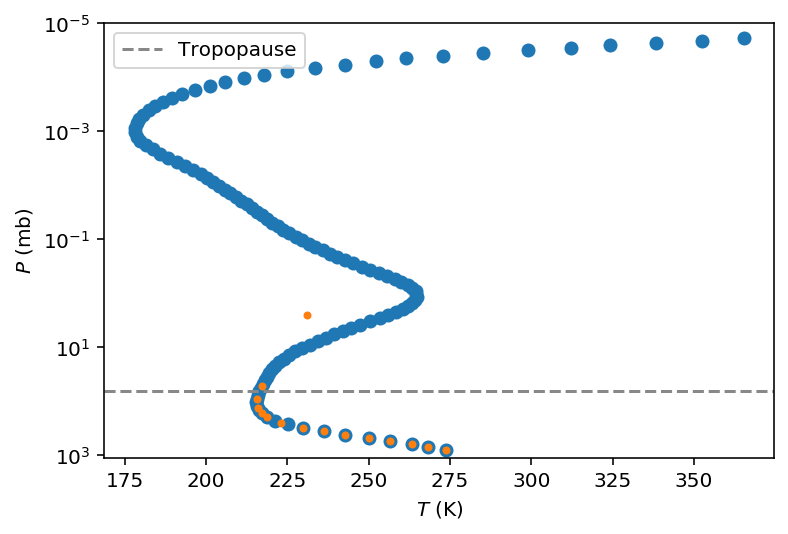

In [19]:
plt.plot(ngt_atm['TEM [K]'].values, ngt_atm['PRE [mb]'],'o', label=None)
plt.plot(bin_atm['TEM [K]'].values, bin_atm['PRE [mb]'], '.',label=None)
plt.axhline(ngt_atm.loc[17, 'PRE [mb]'], linestyle='dashed', color='#888888', label='Tropopause')
plt.ylim(1100, 1e-5); plt.yscale('log'); plt.ylabel('$P$ (mb)'); plt.xlabel('$T$ (K)');

plt.legend();

What matters is the column density.

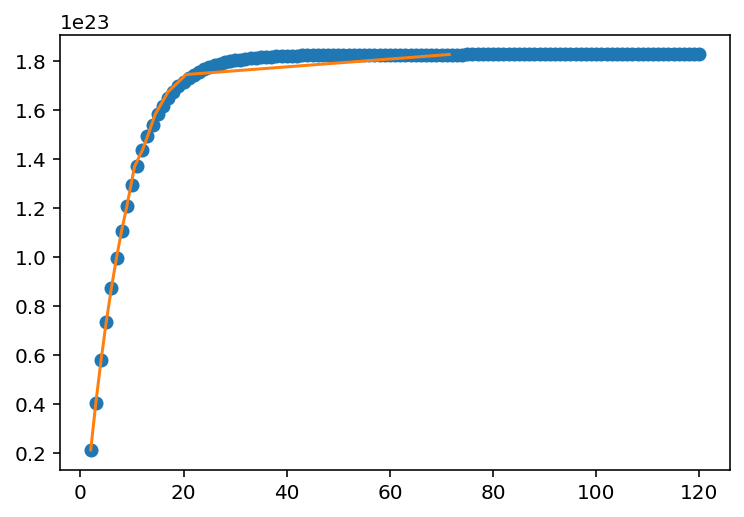

In [20]:
plt.plot(ngt_atm['HGT [km]'],(ngt_atm['dens [cc]']*ngt_atm['path_length_km']).cumsum(),  'o',label=None)
plt.plot(bin_atm['HGT [km]'],(bin_atm['dens [cc]']*bin_atm['path_length_km']).cumsum(),  '-',label=None)
#plt.ylim(2e23)

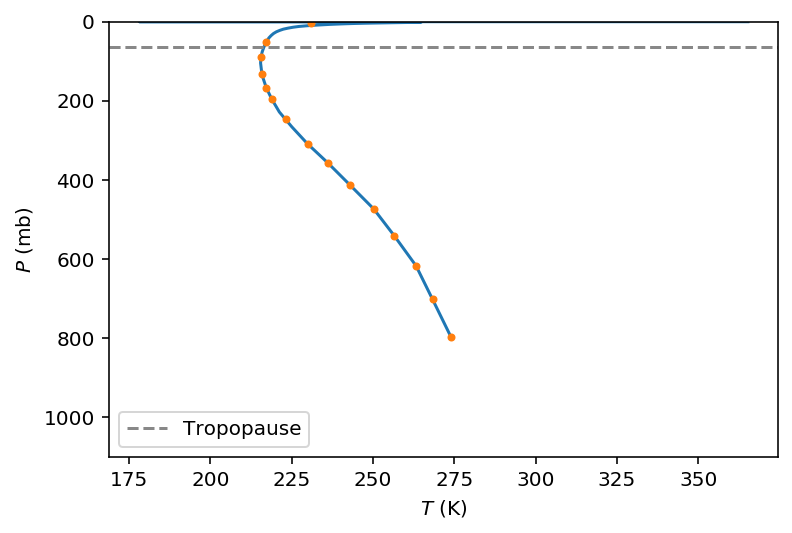

In [21]:
plt.plot(ngt_atm['TEM [K]'].values, ngt_atm['PRE [mb]'], label=None)
plt.plot(bin_atm['TEM [K]'].values, bin_atm['PRE [mb]'], '.',label=None)
plt.axhline(ngt_atm.loc[17, 'PRE [mb]'], linestyle='dashed', color='#888888', label='Tropopause')
plt.ylim(1100, 0); plt.yscale('linear'); plt.ylabel('$P$ (mb)'); plt.xlabel('$T$ (K)');

plt.legend();

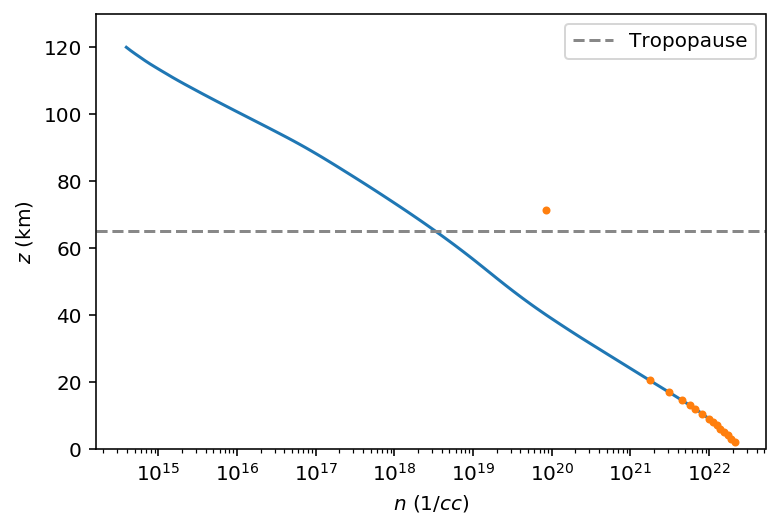

In [22]:
plt.plot(ngt_atm['dens [cc]'].values, ngt_atm['HGT [km]'], label=None)
plt.plot(bin_atm['dens [cc]'].values, bin_atm['HGT [km]'], '.',label=None)
plt.axhline(ngt_atm.loc[17, 'PRE [mb]'], linestyle='dashed', color='#888888', label='Tropopause')
plt.ylim(0, 130); plt.xscale('log'); plt.ylabel('$z$ (km)'); plt.xlabel('$n$ ($1/cc$)');

#for temp in temp_control_points:
#    plt.axvline(temp, color='r')

plt.legend();

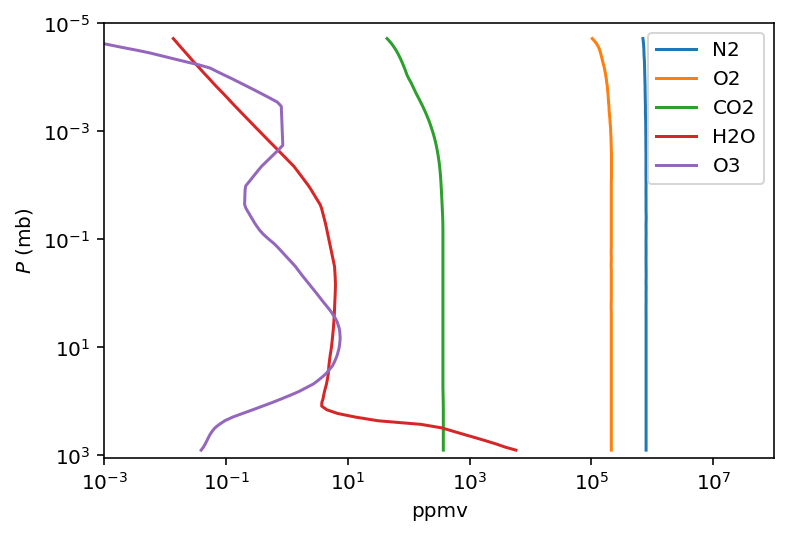

In [23]:
for species in ['N2', 'O2', 'CO2', 'H2O', 'O3']:
    plt.plot(ngt_atm[species+' [ppmv]'], ngt_atm['PRE [mb]'], label=species)
plt.ylim(1100, 1e-5); plt.yscale('log'); plt.ylabel('$P$ (mb)'); plt.xlabel('ppmv');
plt.xlim(1e-3, 1e8); plt.xscale('log'); plt.legend();

## Net transmission
The net $\tau$ is the sum of the optical depths.

In [24]:
@jit
def transmission_multilayer_atmosphere(T_vec, p_vec, vol_mix_ratio, path_length_km, airmass, nus, atomic_data=None):
    '''Compute transmission through a mutlilayer atmosphere'''
    
    net_tau = vmap(partial(tau_of_T_p, atomic_data=atomic_data),
                in_axes=(0,0,None,0,0)
                )(T_vec, P_vec, nus, path_length_km*airmass, vol_mix_ratio).sum(axis=0)
    return np.exp(-1.0*net_tau)

In [25]:
wls = np.linspace(12620, 12790, 18000)
nus = np.array((wls*u.Angstrom).to(1/u.cm, equivalencies=u.spectral()).value)
nus.shape

(18000,)

Rebin the atmosphere profile into nearly continuous steps.

In [26]:
T_vec, P_vec, height_vec, path_vec = (np.array(bin_atm['TEM [K]'].values), 
           np.array(bin_atm['PRE [mb]'].values/1013.25),
           np.array(bin_atm['HGT [km]'].values),
            np.array(bin_atm['path_length_km'].values))

Trim the linelist to the region of interest, with about 230 spectral lines.

In [27]:
O2_hitran_all = get_hapi_molec_data('O2')
mask = (O2_hitran_all[5] > nus.min()) & (O2_hitran_all[5] < nus.max())

In [28]:
O2_hitran = [arr[mask] for arr in O2_hitran_all]

In [29]:
O2_concentration_profile = np.array(bin_atm['O2 [ppmv]'].values*1.0e-6)

In [30]:
t0 = time.time()
O2_spectrum = transmission_multilayer_atmosphere(T_vec, P_vec, O2_concentration_profile, 
                                                 path_vec, 1.22, nus, 
                                          atomic_data=O2_hitran)

print(O2_spectrum[0], time.time() - t0)

0.99826324 0.3411409854888916


Now let's smooth it to the HPF resolution:

In [31]:
sig, mu = 9.12475418, -4.83135231 #determined experimentally
xx = np.linspace(-100, 100, 200)
slit_kernel = 1/(sig*np.sqrt(2*np.pi))*np.exp(-0.5*((xx-mu)/sig)**2) 

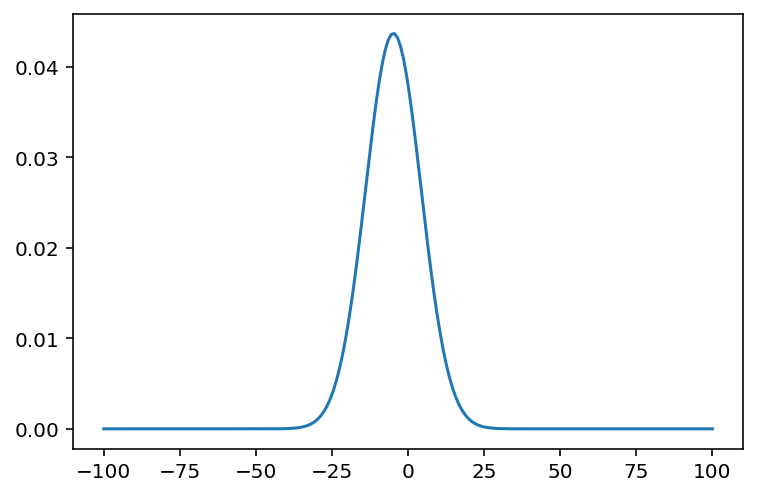

In [32]:
plt.plot(xx, slit_kernel)

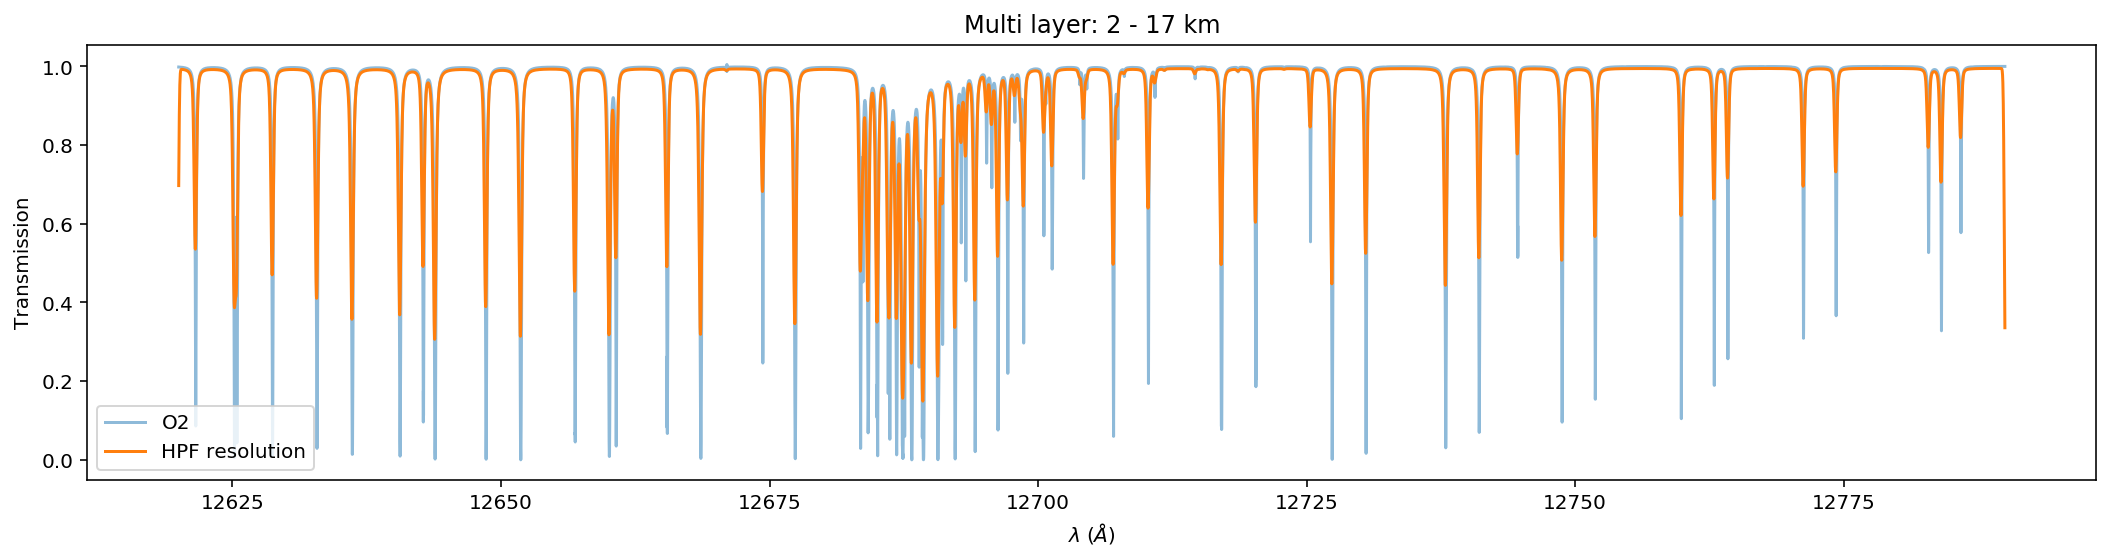

In [33]:
plt.figure(figsize=(18,4))
plt.plot(wls, O2_spectrum, label='O2', alpha=0.5)
plt.plot(wls, np.convolve(O2_spectrum, slit_kernel, mode='same'), label='HPF resolution')

plt.legend(loc='lower left')
plt.ylabel('Transmission')
plt.xlabel('$\lambda \;(\AA)$')
plt.title('Multi layer: 2 - 17 km');

## Get real HPF data

In [34]:
import numpy as onp
from astropy.io import fits
from astropy.table import Table

In [35]:
! ls /home/gully/GitHub/hopful/data/HPF/Dropbox/5-Vul

Slope-20190417T094236_R01_0040.optimal.fits
Slope-20190417T094621_R01_0041.optimal.fits
Slope-20190417T095007_R01_0042.optimal.fits


In [36]:
hdus = fits.open('../../hopful/data/HPF/Dropbox/5-Vul/Slope-20190417T094621_R01_0041.optimal.fits')

In [37]:
df_all = pd.DataFrame()
for m in range(28):
    tab = Table({hdus[i].name:hdus[i].data[m,:] for i in range(1,10)})
    tab['order'] = m
    df_all = df_all.append(tab.to_pandas(), ignore_index=True)

In [38]:
df_all = df_all[(df_all.order ==27) & (df_all['Sci Flux']==df_all['Sci Flux'])].reset_index(drop=True)

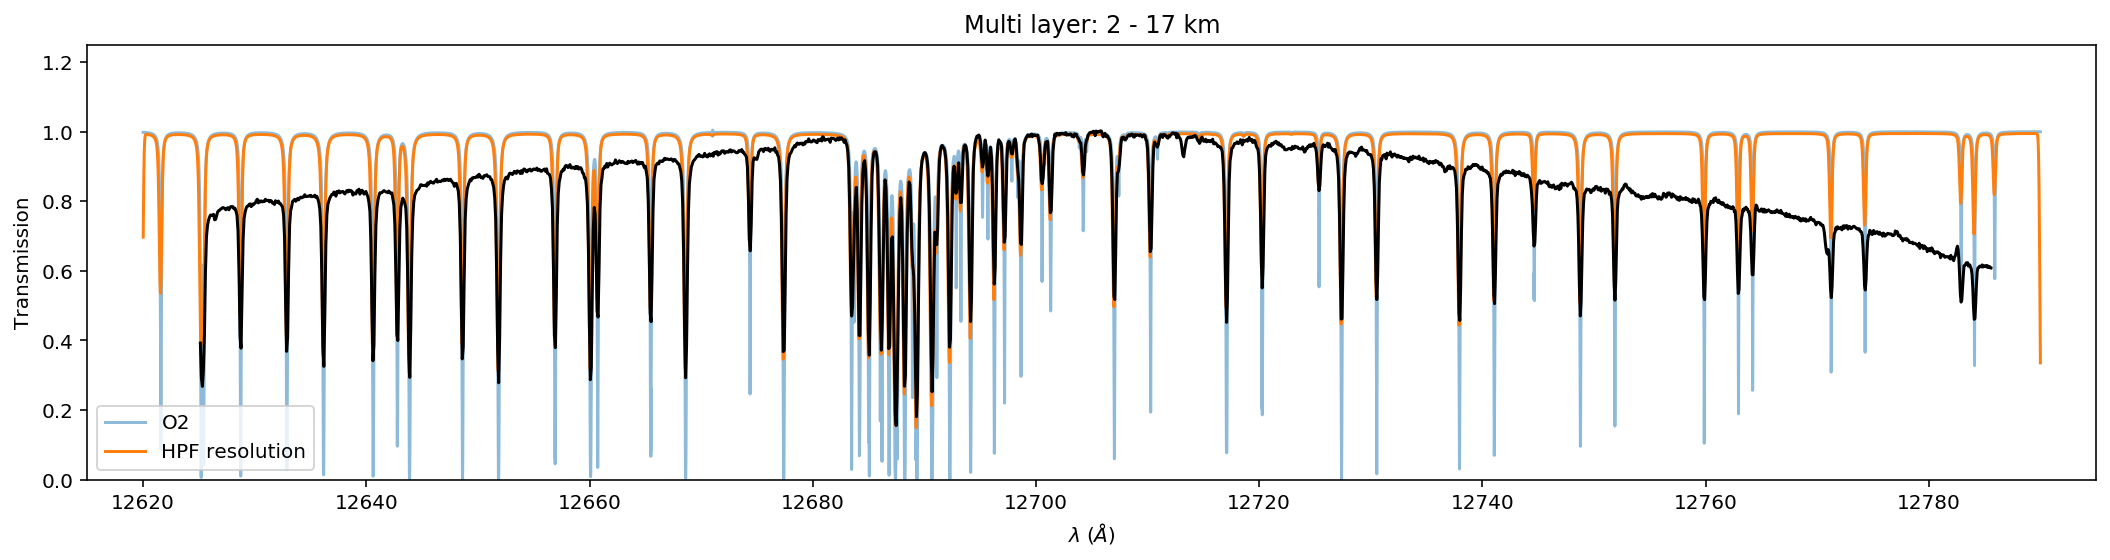

In [39]:
plt.figure(figsize=(18,4))

plt.plot(df_all['Sci Wavl'], df_all['Sci Flux']/onp.median(df_all['Sci Flux'])/1.18, color='k', zorder=10)

plt.plot(wls, O2_spectrum, label='O2', alpha=0.5)
plt.plot(wls, np.convolve(O2_spectrum, slit_kernel, mode='same'), label='HPF resolution')


plt.legend(loc='lower left')
plt.ylabel('Transmission')
plt.xlim(12615, 12795); plt.ylim(0,1.25)
plt.xlabel('$\lambda \;(\AA)$')
plt.title('Multi layer: 2 - 17 km');

Ok, close to the HPF resolution!

## Pre-process the HPF data

Match raw wavelength gridpoints to the over-sampled model wavelengths.

In [40]:
obs_wl = np.array(df_all['Sci Wavl'].values)
nu_hpf = np.array((obs_wl*u.Angstrom).to(1/u.cm, equivalencies=u.spectral()).value)
inds = np.array(np.digitize(wls, obs_wl)) 

Scale the flux to a max of 1.0

In [41]:
scalar_normalization = onp.percentile(df_all['Sci Flux'], 98)
obs_flux = np.array(df_all['Sci Flux'].values/scalar_normalization)

Rescale the uncertainty.

In [42]:
sigma_noise = np.float32(onp.median(onp.sqrt(df_all['Sci Variance'].values)/scalar_normalization))
sigma_noise

DeviceArray(0.00294035, dtype=float32)

Wow, it's $S/N=300$!

### Forward model the blaze shape with polynomials
Eventually we could use Chebyshev Polynomials

In [43]:
@jit
def mean_model_func(T_input, sig, mu, xx):
    '''Return the rebinned spectrum, uses global arrays for now'''
    noise_free_spectrum_native = transmission_multilayer_atmosphere(T_input, P_vec, 
                                                                    O2_concentration_profile, path_vec, 1.22041, nus, 
                                                                    atomic_data=O2_hitran)
    
    slit_kernel = 1/(sig*np.sqrt(2*np.pi))*np.exp(-0.5*((xx-mu)/sig)**2) 
    noise_free_spectrum_high_sampling = np.convolve(noise_free_spectrum_native, slit_kernel, mode='same')
    rebinned_spectrum = np.array([noise_free_spectrum_high_sampling[inds == i].mean() for i in range(2040)])
    return rebinned_spectrum

In [44]:
a_guess = -0.29
b_guess = -0.03
c_guess = 1.0
t_guess = 0.0
vec = (obs_wl-12700.0)/80
blaze_guess = a_guess*vec**2 + b_guess*vec + c_guess + t_guess*vec**3

In [45]:
hdr = hdus[0].header
zenith_angle = hdr['ZA']
airmass_est = 1.0/onp.cos(onp.radians(zenith_angle))
airmass_est

1.2204099499339192

In [46]:
xx = np.linspace(-100, 100, 200)

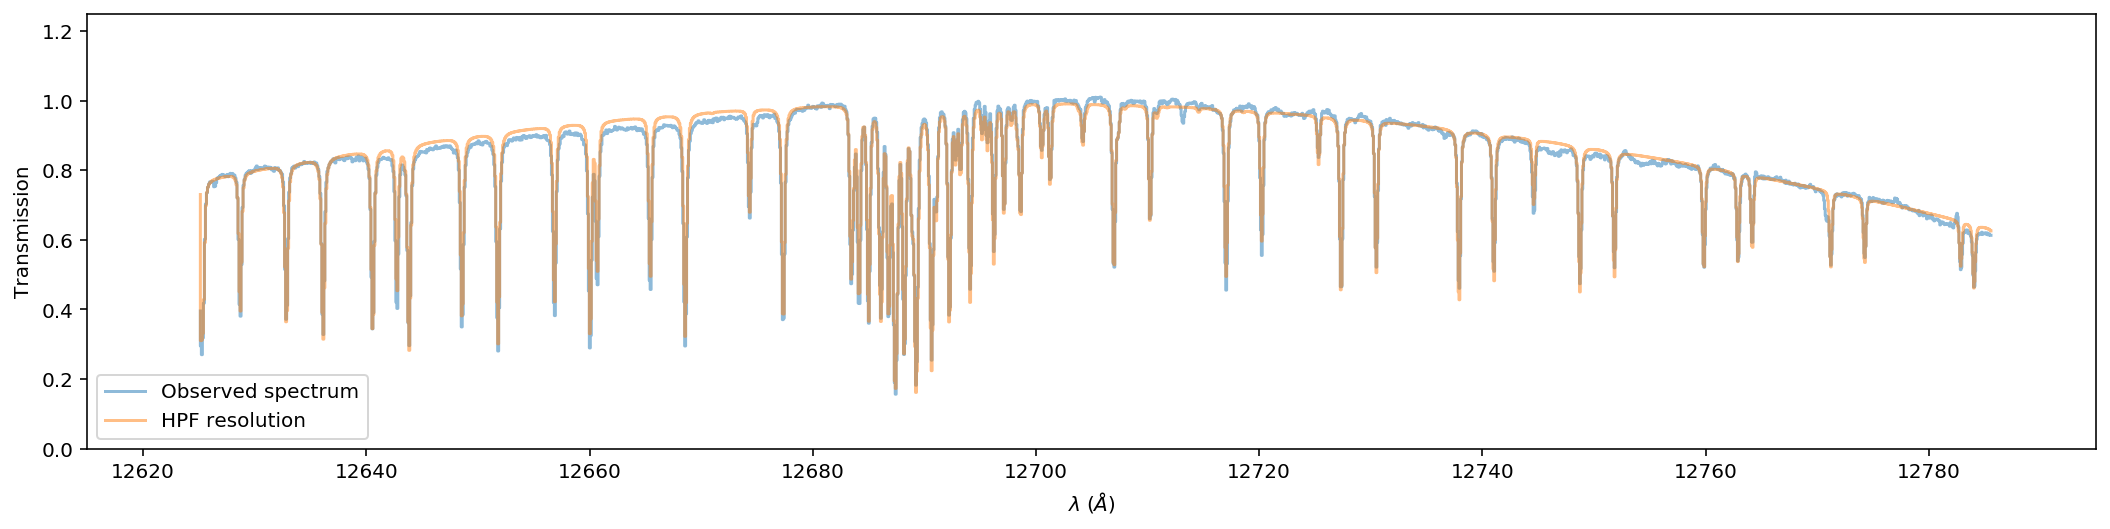

In [47]:
plt.figure(figsize=(18,4))
plt.step(obs_wl, obs_flux, label='Observed spectrum', alpha=0.5)

plt.step(obs_wl, mean_model_func(T_vec, 9.12475418, -4.83135231, xx)*blaze_guess, label='HPF resolution', alpha=0.5)

plt.legend(loc='lower left')
plt.ylabel('Transmission')
plt.xlim(12615, 12795); plt.ylim(0,1.25)
plt.xlabel('$\lambda \;(\AA)$');

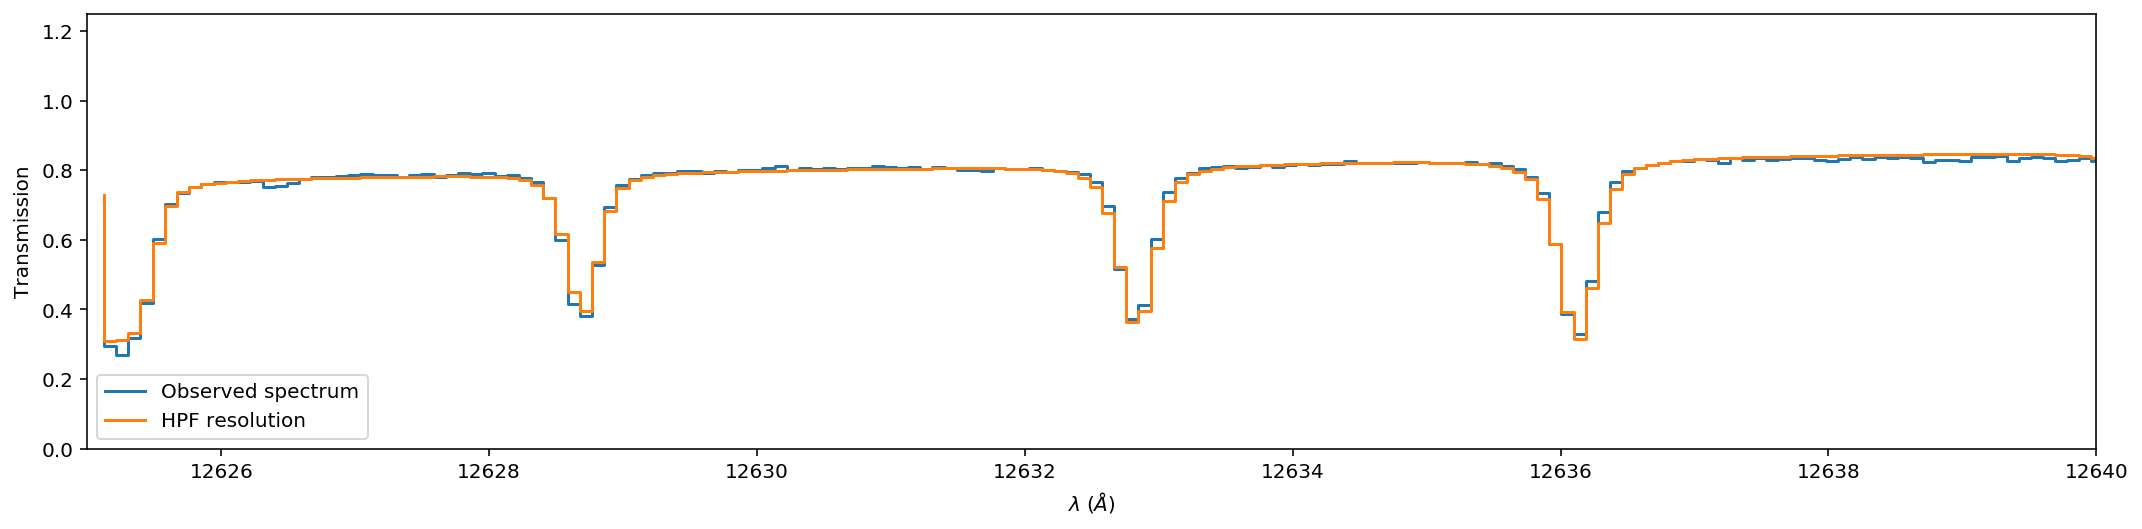

In [48]:
plt.figure(figsize=(18,4))
plt.step(obs_wl, obs_flux, label='Observed spectrum')

plt.step(obs_wl, mean_model_func(T_vec, 9.12475418, -4.83135231, xx)*blaze_guess, label='HPF resolution')

plt.legend(loc='lower left')
plt.ylabel('Transmission')
plt.xlim(12625, 12640); plt.ylim(0,1.25)
plt.xlabel('$\lambda \;(\AA)$');

## Hamiltonian MCMC with numpyro

In [49]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

`vec` will remain a global here for now

In [50]:
vec = (obs_wl-12700.0)/80

In [51]:
#%load https://github.com/pyro-ppl/numpyro/blob/27acd146fadcbcb34711ce093c962f19a2ae37b3/test/test_mcmc.py#L454:466

In [52]:
#import scipy

Spot-check the priors by sampling from them.

```python
def model():
    numpyro.sample('x', dist.LogNormal(np.linspace(5.3, 5.5, 2),0.1*np.ones(2)), sample_shape=(1,))

mcmc = MCMC(NUTS(model), 1000, 5000)
mcmc.run(random.PRNGKey(0), extra_fields=('num_steps', 'adapt_state.step_size'))

samples = mcmc.get_samples(group_by_chain=False)

samples['x'].shape

bins = onp.arange(0, 350.0, 1.0)
plt.hist(samples['x'][:,0,1], bins=bins, density=True);
plt.hist(samples['x'][:,0,0], bins=bins, density=True);
plt.plot(bins, scipy.stats.lognorm(1.0, loc=270.0, scale=20.0).pdf(bins))
```

In [53]:
def model(T_init):
    T_profs = numpyro.sample("T", dist.Uniform(T_init-30.0, T_init+30.0))
    aa = -0.29437405 #numpyro.sample("a", dist.Normal(-0.29, 0.1))
    bb = -0.00572985 #numpyro.sample("b", dist.Normal(-0.03, 0.1))
    cc = 0.99464985 #numpyro.sample("c", dist.Normal(1.0, 0.1))
    dd = -0.02619905 #numpyro.sample("d", dist.Normal(0.0, 0.1))
    mean_blaze = aa * vec**2 + bb * vec + cc + dd * vec**3
    
    pw, pl= 9.12475418, -4.83135231 #numpyro.sample("w", dist.Uniform(1.0, 18.0))
    
    mean_model = mean_model_func(T_profs, pw, pl, xx)*mean_blaze
    numpyro.sample("obs", dist.Normal(mean_model[1:], 0.003*np.ones(2040-1)), obs=obs_flux[1:])

In [54]:
from numpyro.infer import init_to_value

In [55]:
init_params = {'T':T_vec}

In [56]:
rng = random.PRNGKey(0)
rng, rng_ = random.split(rng)

# Run NUTS.
kernel = NUTS(model, dense_mass=True,init_strategy=init_to_value(values=init_params))

In [57]:
num_warmup, num_samples = 500, 1500

In [58]:
mcmc = MCMC(kernel, num_warmup, num_samples, num_chains=1)#, 
            #progress_bar=True, jit_model_args=True, chain_method='vectorized')

In [59]:
%%time
mcmc._compile(rng, T_vec, init_params=init_params)

CPU times: user 7min 39s, sys: 6.15 s, total: 7min 45s
Wall time: 9min 38s


In [60]:
mcmc.run(rng_, T_vec, init_params=init_params)

sample: 100%|██████████| 2000/2000 [08:57<00:00,  3.72it/s, 15 steps of size 2.49e-01. acc. prob=0.94]


It took 3h45m to do 1677 samples.  Let's cut it off.

In [61]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      T[0]    303.72      0.18    303.77    303.46    303.91   1959.72      1.00
      T[1]    298.05      0.25    298.14    297.71    298.30   2152.82      1.00
      T[2]    292.92      0.31    293.01    292.50    293.24   1828.29      1.00
      T[3]    228.43      1.30    228.21    226.56    230.28   1078.88      1.00
      T[4]    221.14      0.85    220.88    220.20    222.34   1484.90      1.00
      T[5]    213.47      0.67    213.25    212.82    214.32   1491.24      1.00
      T[6]    206.72      0.55    206.54    206.17    207.44   1864.97      1.00
      T[7]    200.40      0.53    200.23    199.87    201.16   2140.06      1.00
      T[8]    193.70      0.55    193.52    193.12    194.40   1860.96      1.00
      T[9]    189.79      0.89    189.51    188.85    190.94   1914.38      1.00
     T[10]    188.50      1.29    188.12    187.19    190.21   2197.73      1.00
     T[11]    244.22      1

In [62]:
samples = mcmc.get_samples(group_by_chain=False)

In [63]:
keys = samples.keys()

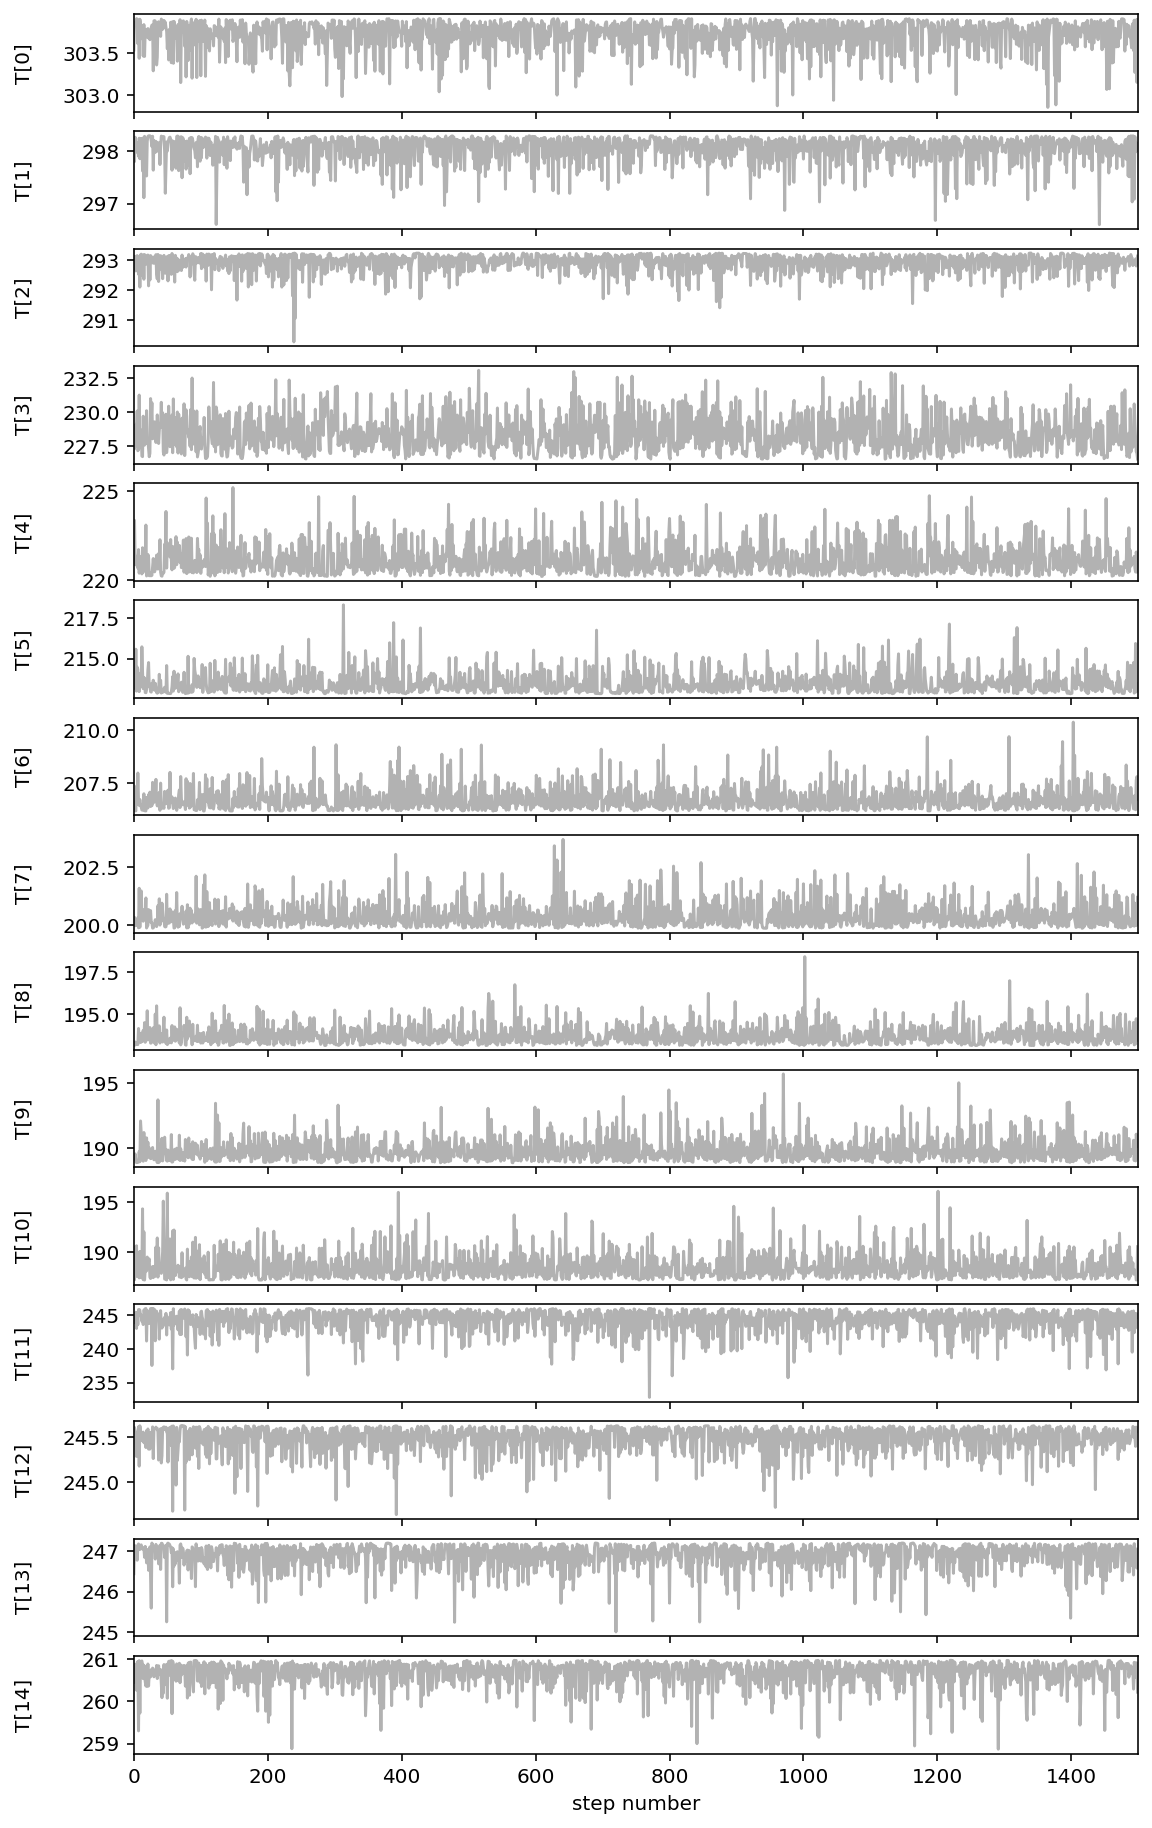

In [64]:
if 'T' not in keys:
    fig, axes = plt.subplots(len(keys), figsize=(9, 4), sharex=True)
    samples = mcmc.get_samples(group_by_chain=False)
    for i, val in enumerate(keys):
        ax = axes[i]
        ax.plot(samples[val][:], "k", alpha=0.3)
        ax.set_xlim(0, num_samples)
        ax.set_ylabel(val)
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number");
else:
    fig, axes = plt.subplots(15, figsize=(9, 16), sharex=True)
    samples = mcmc.get_samples(group_by_chain=False)
    for i in range(15):
        ax = axes[i]
        ax.plot(samples['T'][:,i], "k", alpha=0.3)
        ax.set_xlim(0, num_samples)
        #ax.axhline(T_vec[i], color='r', linestyle='dotted')
        ax.set_ylabel('T[{}]'.format(i))
        ax.yaxis.set_label_coords(-0.1, 0.5)
        #ax.set_ylim(200, 300)

    axes[-1].set_xlabel("step number");

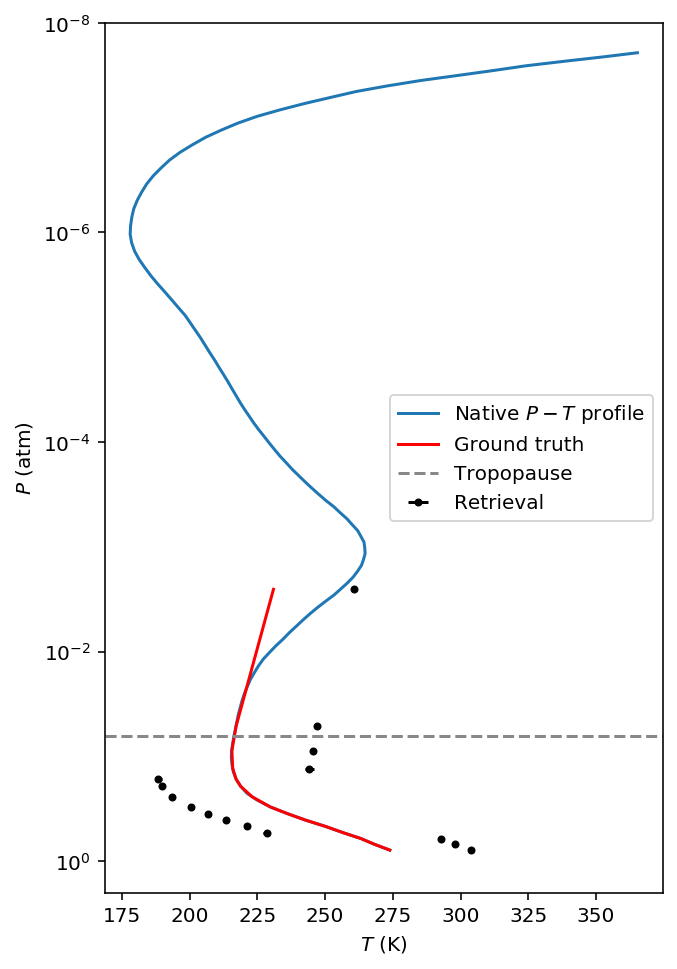

In [65]:
plt.figure(figsize=(5,8))
plt.plot(ngt_atm['TEM [K]'], ngt_atm['PRE [mb]']/1013.25, label='Native $P-T$ profile')
plt.errorbar(samples['T'][150:, :].mean(axis=0), P_vec, xerr=samples['T'].std(axis=0), ecolor='k', 
             fmt='.', color='k', label='Retrieval')
plt.plot(T_vec, P_vec, color='r', label='Ground truth')

plt.axhline(ngt_atm.loc[17, 'PRE [mb]']/1013.25, linestyle='dashed', color='#888888', label='Tropopause')
plt.ylim(2, 1e-8); plt.yscale('log'); plt.ylabel('$P$ (atm)'); plt.xlabel('$T$ (K)');
plt.legend(loc='center right');
plt.yscale('log')

Insight! The T-P profile fitting is going off the rails due to un-modeled physics.  Here are the next steps: 

## Next steps

### 1) Use a Voigt Profile   
We are currently using a Lorentzian, let's convolve the per-line Lorentzian with a per-line Gaussian to yield the Voigt profile.  We will need to add a new pair of functions to do this, and it will likely slow down the code.

### 2) Use a Gaussian Process likelihood  
It should address two issues-- the continuum shape and the line-residual outliers.

### 3) Compare the real T-P profile to generic mid-latitude average  
Retrieve the NOAA atmosphere sounding for McD for the date of observation.  Maybe the HRRR if it's available.  

### 4) Attempt other spectral orders and species  
Try H2O and CO2 in other spectral orders.  Is O2 easier because it has few isolated lines?  The O2 lines also appear to have a finite amount of self-emission, so these lines might be a bit subtle to predict perfectly.

In [66]:
ii = 298

In [67]:
posterior_draw = mean_model_func(samples['T'][ii,:], 9.12475418, -4.83135231, xx)
init_draw = mean_model_func(T_vec, 9.12475418, -4.83135231, xx)

In [68]:
aa = -0.29437405 #numpyro.sample("a", dist.Normal(-0.29, 0.1))
bb = -0.00572985 #numpyro.sample("b", dist.Normal(-0.03, 0.1))
cc = 0.99464985 #numpyro.sample("c", dist.Normal(1.0, 0.1))
dd = -0.02619905 #numpyro.sample("d", dist.Normal(0.0, 0.1))
vec = (obs_wl-12700.0)/80
blaze_draw = aa*vec**2 + bb*vec + cc + dd * vec**3

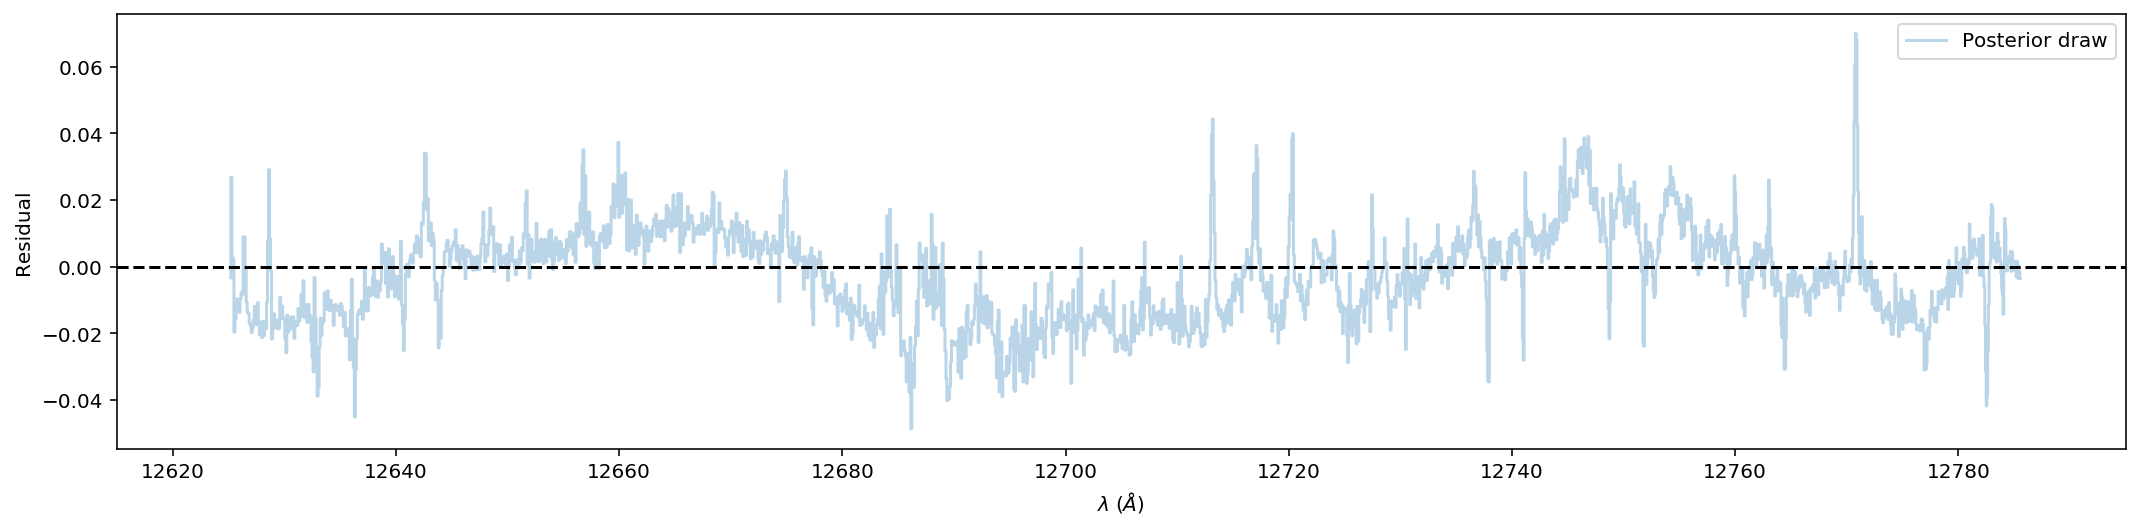

In [69]:
plt.figure(figsize=(18,4))
#plt.plot(obs_wl, obs_flux, label='Observed spectrum')

draw = posterior_draw*blaze_draw
resid = draw-obs_flux
plt.step(obs_wl[1:], resid[1:], label='Posterior draw', alpha=0.3)
#plt.step(obs_wl, init_draw*blaze_draw-obs_flux, label='Init draw', alpha=0.3)
plt.axhline(0, color='k', linestyle='dashed')


plt.legend(loc='best')
plt.ylabel('Residual')
plt.xlim(12615, 12795); #plt.ylim(0,1.25)
plt.xlabel('$\lambda \;(\AA)$');

In [71]:
import seaborn as sns

In [72]:
mask = 1-onp.diagflat(np.ones(15)*onp.NaN)

In [73]:
cov_mat = onp.corrcoef(samples['T'][200:,:], rowvar=False)

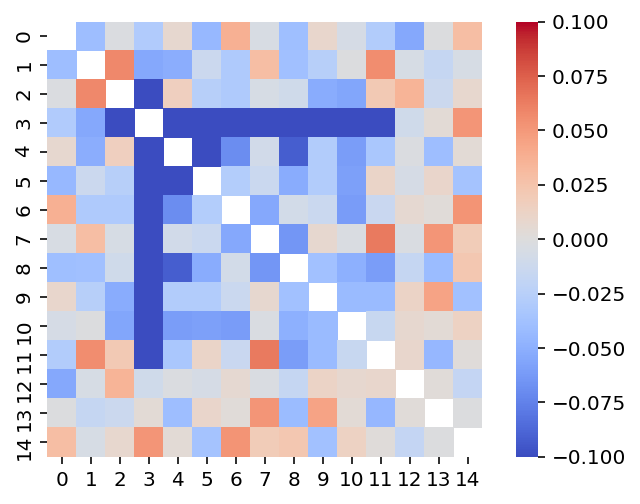

In [74]:
sns.heatmap(cov_mat*mask, square=True, vmin=-0.1, vmax=0.1, cmap='coolwarm');

Hmm, some atmosphere layer is strongly anticorrelated with others?